In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt

In [2]:
words = open("names.txt", 'r').read().splitlines()

In [16]:
chrs = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chrs)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}

{1: 'a',
 2: 'b',
 3: 'c',
 4: 'd',
 5: 'e',
 6: 'f',
 7: 'g',
 8: 'h',
 9: 'i',
 10: 'j',
 11: 'k',
 12: 'l',
 13: 'm',
 14: 'n',
 15: 'o',
 16: 'p',
 17: 'q',
 18: 'r',
 19: 's',
 20: 't',
 21: 'u',
 22: 'v',
 23: 'w',
 24: 'x',
 25: 'y',
 26: 'z',
 0: '.'}

In [162]:
#build the dataset
def b_dataset(block_size,words):
    #predicting 4th character given the  three characters
    inputs , labels = [] , []
    for w in words:
        context = [0] * block_size
        for ch in w + '.':
            ix = stoi[ch]
            inputs.append(context)
            labels.append(ix)
            # print(f"character {ch}")
            # print(''.join(itos[i] for i in context), '--->' , itos[ix])
            context = context[1:] + [ix] #crop the context and enter new character into the window
            # print(f"this is context {context}")
    inputs = torch.tensor(inputs)
    labels = torch.tensor(labels)
    return inputs, labels

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8 * len(words))
n2 = int(0.9 * len(words))

Xtr , Ytr = b_dataset(3, words[:n1])
Xval, Yval = b_dataset(3, words[n1:n2])
Xte , Yte = b_dataset(3, words[n2:])


In [177]:
#build embedding 
g = torch.Generator().manual_seed(2147483647)
C = torch.randn((27,10),generator=g) #embedding in two dimension 
#hidden layer 1
W1 = torch.randn((30,200),generator=g)
b1 = torch.randn(200,generator=g)
#hidden layer 2
W2 = torch.randn((200,27),generator=g)
b2 = torch.randn(27,generator=g)
parameters = [C, W1, b1, W2, b2]

In [178]:
for p in parameters:
    p.requires_grad = True

In [179]:
lr = torch.linspace(-3, 0, 1000)
lrs = 10**lr # 0.001 , 1

In [180]:
lri = []
lossi = []
stepi  = []

In [183]:

for i in range(30000):
    #creating mini batches
    ix = torch.randint(0, Xtr.shape[0], (32,))
    
    
    #forward pass
    emb = C[Xtr[ix]]
    h = torch.tanh(emb.view(emb.shape[0],30) @ W1 + b1)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, Ytr[ix])

    print(loss.item())

    #backward pass
    for p in parameters:
        p.grad = None #setting all the gradients to none
    loss.backward() #get the gradient

    #update
    #lr = lrs[i]
    lr = 0.01
    for p in parameters:
        p.data += -lr * p.grad
    
    #track stats
    lri.append(lr)
    lossi.append(loss.log10().item())
    stepi.append(i)


2.318230628967285
2.022787570953369
2.287937641143799
3.293851613998413
2.416907548904419
2.40120005607605
2.558906078338623
2.4267311096191406
2.336076259613037
2.6304337978363037
2.49814772605896
2.565488576889038
2.1675689220428467
2.572000026702881
2.53061580657959
2.4106264114379883
2.3816659450531006
2.5257198810577393
2.1846296787261963
1.9548670053482056
2.167672634124756
2.23201060295105
2.5577564239501953
2.604893684387207
2.1840646266937256
1.885042667388916
2.1556341648101807
2.3769094944000244
2.1596291065216064
2.0638225078582764
2.07088041305542
1.9454922676086426
2.13521409034729
2.237175464630127
2.259945869445801
1.96546471118927
2.1098484992980957
2.4666037559509277
2.279235363006592
2.2225193977355957
2.3781120777130127
2.308830738067627
1.962673306465149
2.6984522342681885
2.2726190090179443
1.8129255771636963
2.5495455265045166
2.526841640472412
2.2595083713531494
2.0961427688598633
2.567709445953369
2.3053789138793945
2.3071987628936768
2.5497124195098877
1.87109

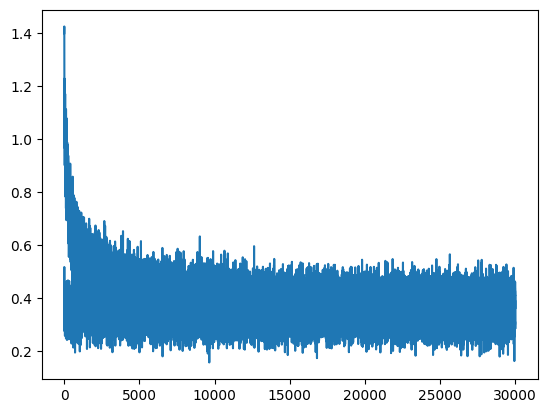

In [184]:
plt.plot(stepi,lossi)

In [150]:
#training split --> train the parameters (weights and biases)
#validation split  --> train the hyperaparameters 
                        #(lr, embeddings, size of hidden layers, number of hidden layers,regularization)
#test split --> evaluate the performance of the model 
                #You only get limited opportunity to test the trained model 
                #or else you would start to overfit. 

In [167]:
#validate
emb = C[Xval]
h = torch.tanh(emb.view(emb.shape[0],6) @ W1 + b1)
logits = h @ W2 + b2
loss = F.cross_entropy(logits, Yval)
loss

tensor(2.4719, grad_fn=<NllLossBackward0>)

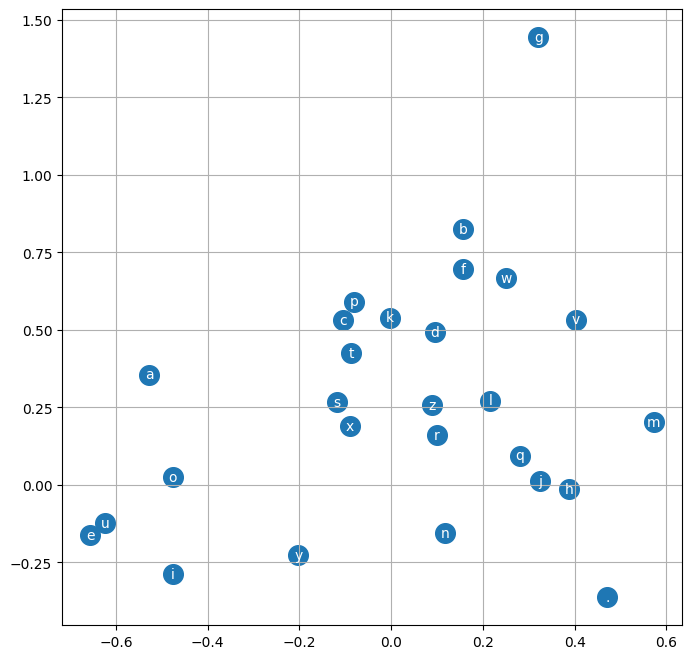

In [175]:
plt.figure(figsize=(8,8))
plt.scatter(C[:,0].data, C[:,1].data , s=200)
for i in range(C.shape[0]):
    plt.text(C[i,0].item(), C[i,1].item(), itos[i], ha="center", va="center", color="white")
plt.grid('minor')
